In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd= 10 # embedding dimension
n_hidden = 200 # number of hidden units in the LSTM

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd * block_size, n_hidden, generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn(n_hidden, vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (batch_size, block_size, n_embd)
  embcat = emb.view(batch_size, -1) # (batch_size, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (batch_size, n_hidden)
  logits = h @ W2 + b2 # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 22.4940
  10000/ 200000: 2.5653
  20000/ 200000: 2.6087
  30000/ 200000: 2.4956
  40000/ 200000: 2.4264
  50000/ 200000: 2.8045
  60000/ 200000: 2.4115
  70000/ 200000: 2.0643
  80000/ 200000: 2.4583
  90000/ 200000: 2.3159
 100000/ 200000: 1.9747
 110000/ 200000: 2.2368
 120000/ 200000: 2.0413
 130000/ 200000: 1.9315
 140000/ 200000: 2.1381
 150000/ 200000: 2.2717
 160000/ 200000: 2.2118
 170000/ 200000: 1.9583
 180000/ 200000: 2.4555
 190000/ 200000: 1.8889


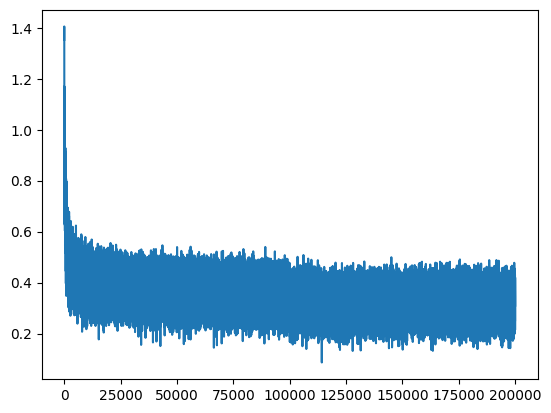

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad()
def split_loss(split):
  x,y = {'train':(Xtr,Ytr), 'val':(Xdev,Ydev), 'test':(Xte,Yte)}[split]
  emb = C[x] # (batch_size, block_size, n_embd)
  embcat = emb.view(x.shape[0], -1) # (batch_size, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (batch_size, n_hidden)
  logits = h @ W2 + b2 # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.1321
val loss: 2.1754


In [9]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carman.
amille.
khi.
milia.
aty.
skansh.
ejukonte.
den.
art.
kaeli.
ner.
kiah.
maiir.
kaleigh.
ham.
pori.
quint.
suline.
liveni.
wajelin.


In [15]:
# the initial loss over a uniform distribution,
# which is the loss we would get if we just guessed randomly
-torch.tensor(1/vocab_size).log().item()

3.295836925506592

In [16]:
# 4 dim example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()  # the label is 2, but it doesn't matter, since all probs are the same
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [18]:
# 4 dim example of the issue
logits = torch.randn(4)
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
probs,loss  # loss is okay

(tensor([0.1368, 0.4101, 0.2469, 0.2062]), tensor(1.3988))

In [22]:
# 4 dim example of the issue
logits = torch.randn(4) * 100
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
probs,loss  # loss is not okay

(tensor([4.9867e-11, 3.1107e-15, 0.0000e+00, 1.0000e+00]), tensor(inf))

### We would like the logits to start as equal (to 0)

In [24]:
n_embd= 10 # embedding dimension
n_hidden = 200 # number of hidden units in the LSTM

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd * block_size, n_hidden, generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01 # we want small equal logits (but not 0 for weights)
b2 = torch.randn(vocab_size, generator=g) * 0 # initialize b2 to 0, because we want the logits to start as equal

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [25]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (batch_size, block_size, n_embd)
  embcat = emb.view(batch_size, -1) # (batch_size, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (batch_size, n_hidden)
  logits = h @ W2 + b2 # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3486
  10000/ 200000: 2.7570
  20000/ 200000: 2.1616
  30000/ 200000: 2.5319
  40000/ 200000: 2.3466
  50000/ 200000: 1.8971
  60000/ 200000: 2.1268
  70000/ 200000: 2.1072
  80000/ 200000: 1.9339
  90000/ 200000: 2.4014
 100000/ 200000: 2.2565
 110000/ 200000: 1.7588
 120000/ 200000: 2.0688
 130000/ 200000: 2.1738
 140000/ 200000: 1.9355
 150000/ 200000: 1.8197
 160000/ 200000: 2.4313
 170000/ 200000: 2.1307
 180000/ 200000: 1.9593
 190000/ 200000: 2.0067


### A de|eper problem is the initialization of the hidden layer

In [27]:
h.shape

torch.Size([32, 200])

In [28]:
h.view(-1).shape

torch.Size([6400])

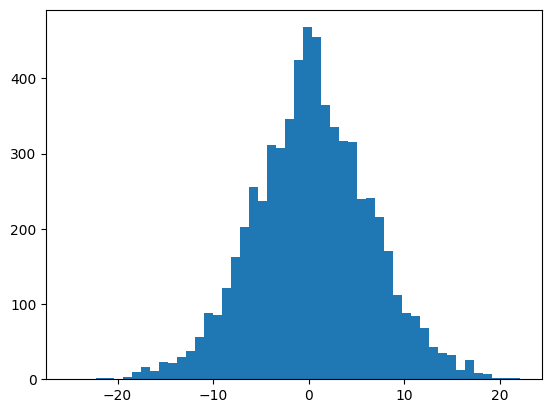

In [39]:
plt.hist((embcat @ W1 + b1).view(-1).tolist(), 50);  # gaussian is too large

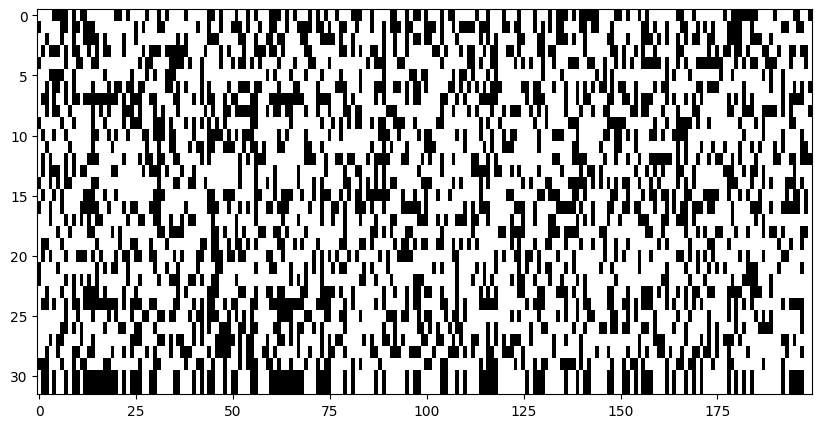

In [38]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest', aspect='auto') # a lot of the hidden units are dead
# there are no columns that are all white or all black

### Tanh gradient is (1 - tanh^2) * out.grad  (see micrograd)
### This means the gradient out.grad is killed every time the values are 1 or -1

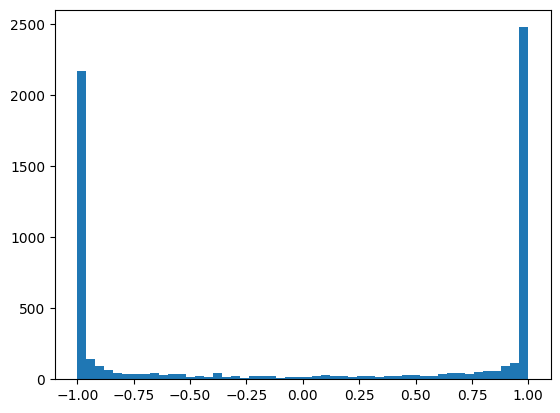

In [40]:
plt.hist(h.view(-1).tolist(), 50); # most neurons are squashed

In [41]:
n_embd= 10 # embedding dimension
n_hidden = 200 # number of hidden units in the LSTM

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd * block_size, n_hidden, generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01 # we want small equal logits (but not 0 for weights)
b2 = torch.randn(vocab_size, generator=g) * 0 # initialize b2 to 0, because we want the logits to start as equal

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [42]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (batch_size, block_size, n_embd)
  embcat = emb.view(batch_size, -1) # (batch_size, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (batch_size, n_hidden)
  logits = h @ W2 + b2 # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break


      0/ 200000: 3.3070


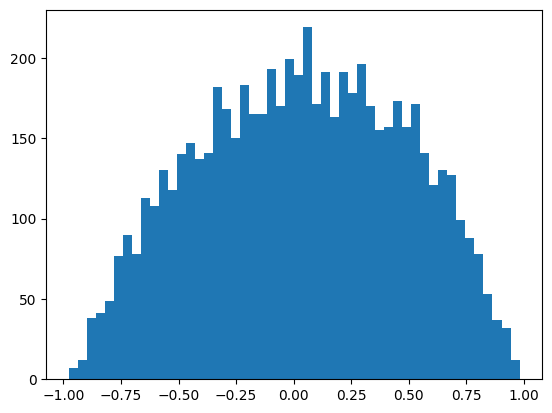

In [43]:
plt.hist(h.view(-1).tolist(), 50); # now becamse gaussian

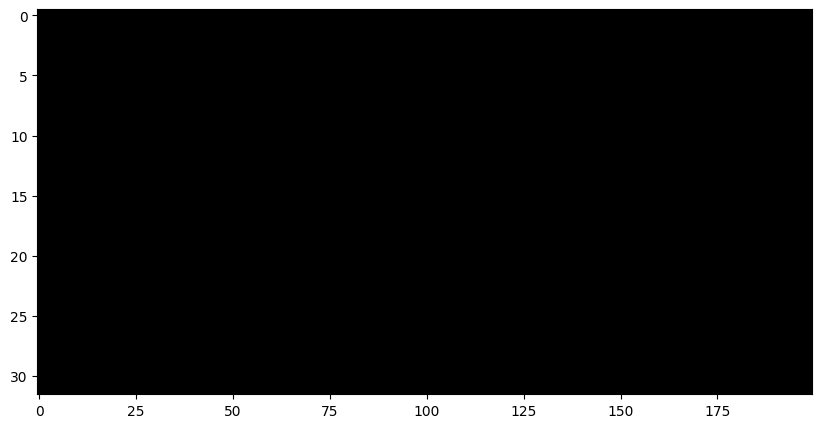

In [44]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest', aspect='auto') # complete black, no neurons saturated

### Kaiming initialization

tensor(0.0144) tensor(0.9989)
tensor(0.0013) tensor(0.9950)


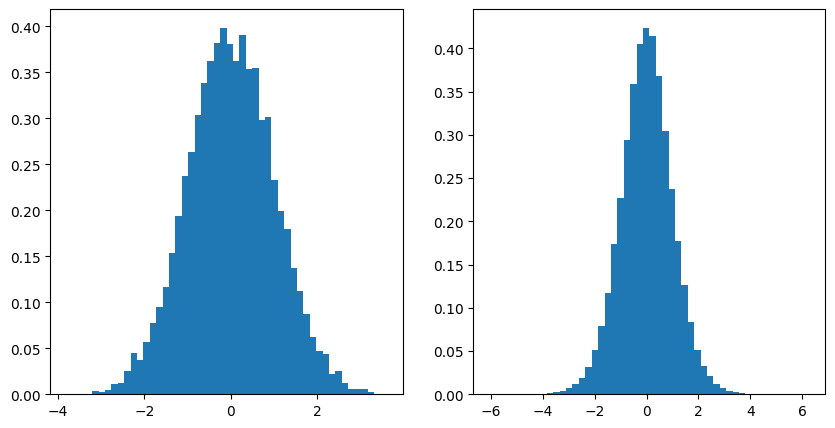

In [50]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5  # dividing by the square root of the number of inputs (fan-in)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

### Retrain

In [57]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [63]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [64]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (batch_size, block_size, n_embd)
  embcat = emb.view(batch_size, -1) # (batch_size, block_size * n_embd)
  h = torch.tanh(embcat @ W1) # (batch_size, n_hidden)
  logits = h @ W2 + b2 # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3031
  10000/ 200000: 1.7301
  20000/ 200000: 2.4900
  30000/ 200000: 2.1668
  40000/ 200000: 2.5323
  50000/ 200000: 2.5153
  60000/ 200000: 2.0286
  70000/ 200000: 1.8331
  80000/ 200000: 1.8945
  90000/ 200000: 1.9166
 100000/ 200000: 2.0732
 110000/ 200000: 2.3618
 120000/ 200000: 2.0708
 130000/ 200000: 1.7255
 140000/ 200000: 2.0409
 150000/ 200000: 1.9654
 160000/ 200000: 2.2701
 170000/ 200000: 2.0821
 180000/ 200000: 1.8592
 190000/ 200000: 2.2435


## Batch Normalization

In [67]:
hpreact = embcat @ W1
hpreact.shape

torch.Size([32, 200])

In [69]:
hpreact.mean(dim=0, keepdim=True).shape  # per batch dimension

torch.Size([1, 200])

In [70]:
hpreact.std(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [71]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [72]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation, bias is useless because it gets subtracted in the next step
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2856
  10000/ 200000: 2.1340
  20000/ 200000: 2.1373
  30000/ 200000: 2.2285
  40000/ 200000: 2.0133
  50000/ 200000: 1.7307
  60000/ 200000: 2.2741
  70000/ 200000: 2.2340
  80000/ 200000: 2.3828
  90000/ 200000: 2.0722
 100000/ 200000: 2.2072
 110000/ 200000: 2.1703
 120000/ 200000: 2.2788
 130000/ 200000: 1.8803
 140000/ 200000: 1.7875
 150000/ 200000: 2.1805
 160000/ 200000: 1.9339
 170000/ 200000: 1.9587
 180000/ 200000: 2.1038
 190000/ 200000: 2.0363


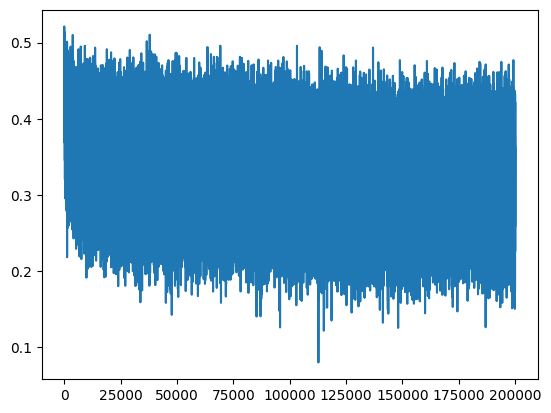

In [73]:
plt.plot(lossi)

### Explicit stage of calibration (Not needed if using running means)

In [74]:
# calibrate the batch norm at the end of training

# with torch.no_grad():
#   # pass the training set through
#   emb = C[Xtr]
#   embcat = emb.view(emb.shape[0], -1)
#   hpreact = embcat @ W1 # + b1
#   # measure the mean/std over the entire training set
#   bnmean = hpreact.mean(0, keepdim=True)
#   bnstd = hpreact.std(0, keepdim=True)


In [75]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0657238960266113
val 2.109697103500366


## PyTorchifying

In [108]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [109]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3313


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.31%
layer 11 (      Tanh): mean -0.01, std 0.64, saturated: 2.81%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%


Text(0.5, 1.0, 'activation distribution')

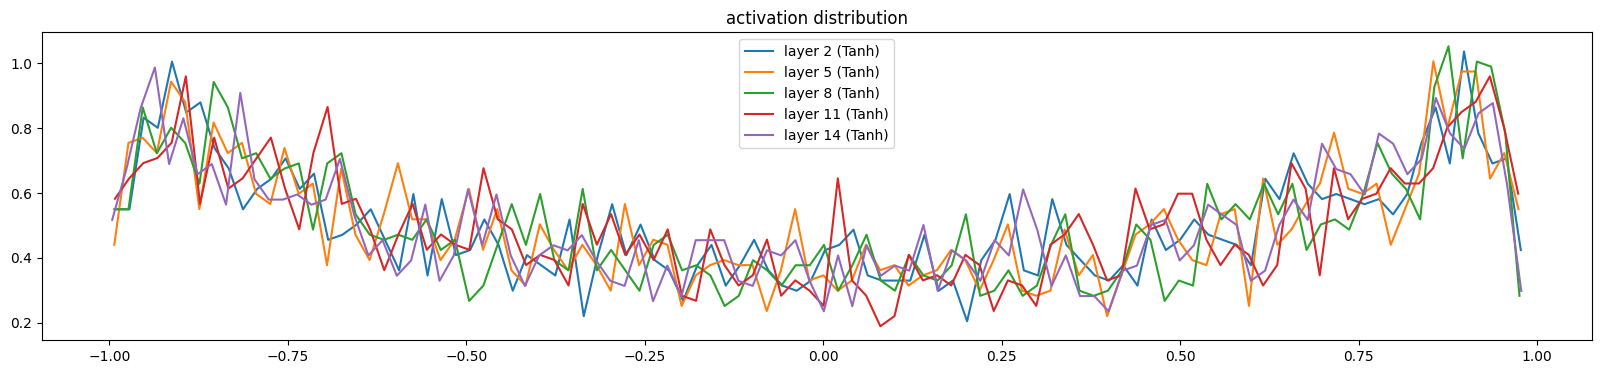

In [110]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.860916e-03
layer 5 (      Tanh): mean +0.000000, std 3.310030e-03
layer 8 (      Tanh): mean -0.000000, std 3.105929e-03
layer 11 (      Tanh): mean +0.000000, std 2.750410e-03
layer 14 (      Tanh): mean +0.000000, std 2.485619e-03


Text(0.5, 1.0, 'gradient distribution')

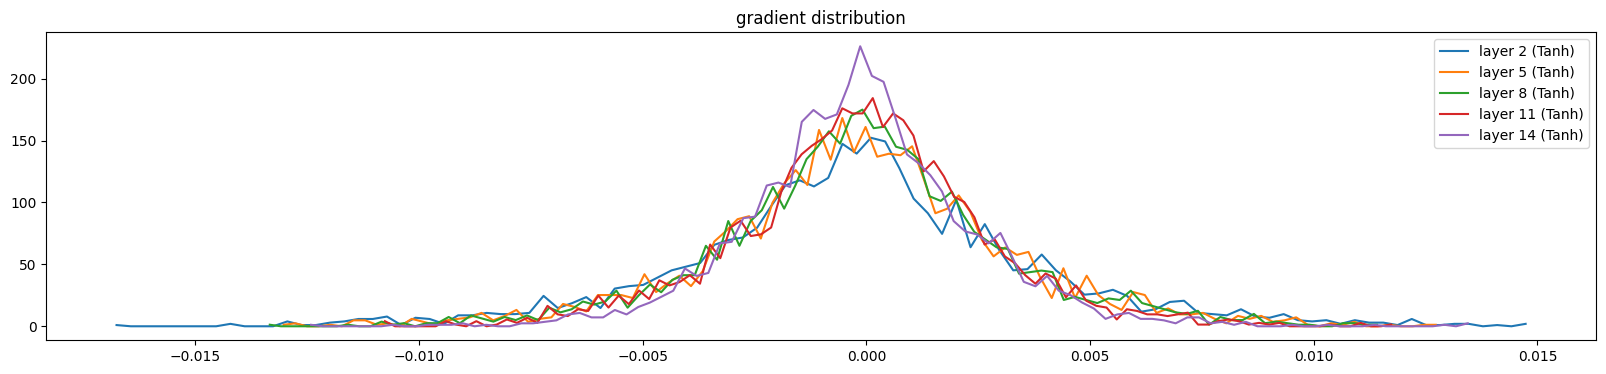

In [111]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.878523e-03 | grad:data ratio 9.868569e-03
weight  (30, 100) | mean -0.000094 | std 8.747962e-03 | grad:data ratio 2.799228e-02
weight (100, 100) | mean +0.000160 | std 7.655439e-03 | grad:data ratio 4.581042e-02
weight (100, 100) | mean +0.000066 | std 6.817395e-03 | grad:data ratio 4.043709e-02
weight (100, 100) | mean +0.000010 | std 6.177768e-03 | grad:data ratio 3.681591e-02
weight (100, 100) | mean +0.000014 | std 5.331899e-03 | grad:data ratio 3.176153e-02
weight  (100, 27) | mean -0.000046 | std 9.655395e-03 | grad:data ratio 5.796682e-02


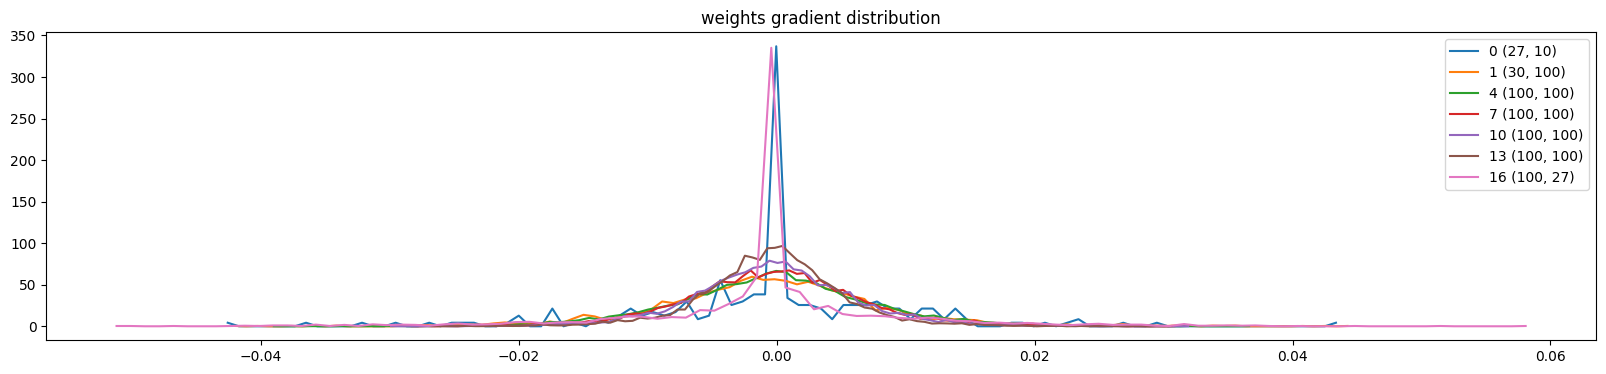

In [112]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

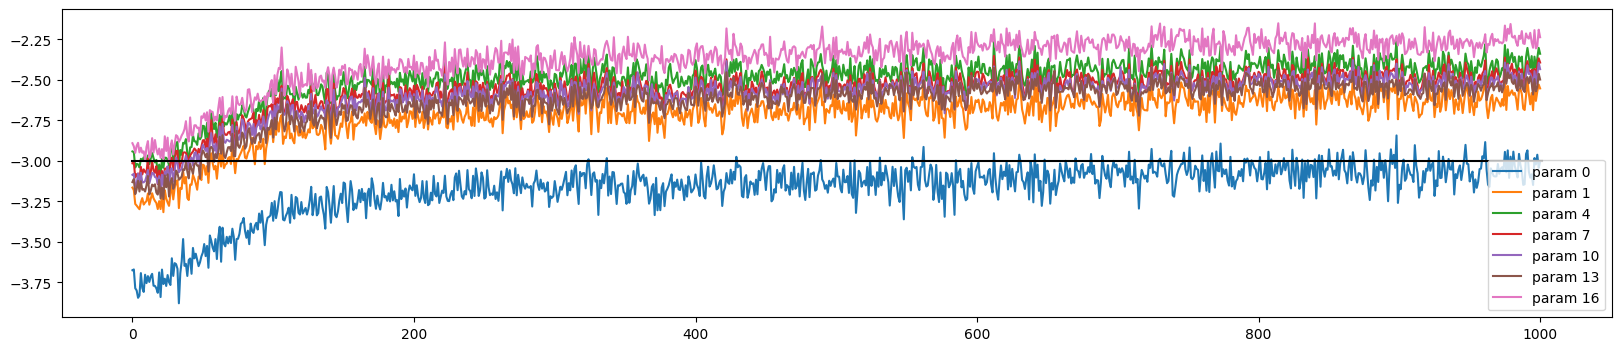

In [113]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:  # only plot weights (not biases), so number of parameters is 2
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [85]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.403294563293457
val 2.402827501296997


In [86]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

careah.
qarylleifi.
mrix.
thtl.
skandan.
jazhnen.
del.
ric.
kaqhiunelania.
chaiiv.
kalein.
dhyma.
din.
qhijthn.
line.
lian.
quiqjero.
dearyxixfine.
pius.
bee.
